In [1]:
import os
import PIL
from PIL import Image
import numpy as np
import json
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import itertools
from torchvision import datasets, transforms, models
from shapley.transform import ThresholdTransform,AddNoise,DetachWhite
from einops import rearrange
from tqdm import tqdm
import os
import PIL
from PIL import Image
import numpy as np
import json
import torch
from torch.utils.data import Dataset, DataLoader
import itertools
from torchvision import datasets, transforms, models
from einops import rearrange
from itertools import product
import random
import math
import torchvision.models as models
topil = transforms.ToPILImage()

/data/jong980812/anaconda3/envs/asd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Image Open

# Model


In [2]:
import torchvision.models as models
model=models.efficientnet_b1(pretrained=True,progress=False)
model.classifier[1] = torch.nn.Linear(1280, 4)
import torchvision
# model=torchvision.models.resnet18()
# in_feat=model.fc.in_features
# model.fc=torch.nn.Linear(in_feat,2)
# data_path='/data/datasets/asd/All_5split/01/val/TD/'
data_path='/data/datasets/ai_hub_sketch_4way/01/val/m_w'
# data_path='/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/w/'
import random
weight='/data/jong980812/project/mae/result_after_shapley/4way/binary_240_0.98_224168/OUT/01/checkpoint-29.pth'
checkpoint = torch.load(weight, map_location='cpu')
print("Load pre-trained checkpoint from: %s" % weight)
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
msg = model.load_state_dict(checkpoint_model, strict=False)
model.eval()
print(msg)

Load pre-trained checkpoint from: /data/jong980812/project/mae/result_after_shapley/4way/binary_240_0.98_224168/OUT/01/checkpoint-29.pth
<All keys matched successfully>


In [3]:
# 'label': '사람전체', 'x': 571, 'y': 275, 'w': 268, 'h': 635},
#    {'label': '머리', 'x': 590, 'y': 278, 'w': 172, 'h': 153},
#    {'label': '얼굴', 'x': 592, 'y': 329, 'w': 168, 'h': 103},
#    {'label': '눈', 'x': 622, 'y': 351, 'w': 34, 'h': 25},
#    {'label': '눈', 'x': 677, 'y': 344, 'w': 39, 'h': 24},
#    {'label': '코', 'x': 663, 'y': 354, 'w': 11, 'h': 26},
#    {'label': '입', 'x': 661, 'y': 384, 'w': 26, 'h': 13},
#    {'label': '귀', 'x': 592, 'y': 362, 'w': 25, 'h': 26},
#    {'label': '귀', 'x': 732, 'y': 350, 'w': 26, 'h': 26},
#    {'label': '머리카락', 'x': 602, 'y': 280, 'w': 144, 'h': 62},
#    {'label': '목', 'x': 668, 'y': 423, 'w': 35, 'h': 25},
#    {'label': '상체', 'x': 639, 'y': 424, 'w': 139, 'h': 180},
#    {'label': '팔', 'x': 579, 'y': 450, 'w': 65, 'h': 202},
#    {'label': '팔', 'x': 757, 'y': 429, 'w': 74, 'h': 175},
#    {'label': '손', 'x': 588, 'y': 607, 'w': 56, 'h': 48},
#    {'label': '손', 'x': 771, 'y': 553, 'w': 60, 'h': 54},
#    {'label': '다리', 'x': 728, 'y': 577, 'w': 105, 'h': 323},
#    {'label': '다리', 'x': 644, 'y': 588, 'w': 119, 'h': 326},
#    {'label': '발', 'x': 691, 'y': 847, 'w': 70, 'h': 67},
#    {'label': '발', 'x': 761, 'y': 833, 'w': 74, 'h': 67},
#    {'label': '단추', 'x': 669, 'y': 455, 'w': 51, 'h': 121},
#    {'label': '주머니', 'x': 646, 'y': 590, 'w': 50, 'h': 64},
#    {'label': '주머니', 'x': 732, 'y': 576, 'w': 57, 'h': 53},
#    {'label': '운동화', 'x': 604, 'y': 914, 'w': 79, 'h': 117},
#    {'label': '운동화', 'x': 679, 'y': 920, 'w': 74, 'h': 106},
#    {'label': '남자구두', 'x': 888, 'y': 752, 'w': 111, 'h': 86},
#    {'label': '남자구두', 'x': 910, 'y': 816, 'w': 131, 'h': 88}]},
part = {
    '사람전체':'human_body',
    '머리':'head',
    '얼굴':'face',
    '눈':'eye',
    '코':'nose',
    '입':'mouth',
    '귀':'ear',
    '머리카락':'hair',
    '목':'neck',
    '상체':'upper_body_else_arm',
    '팔':'arm',
    '손':'hand',
    '다리':'leg',
    '발':'foot',
    '단추':'button',
    '주머니':'pocket',
    '운동화':'sneakers',
    '남자구두':'man_shoes',
    '여자구두':'woman_shoes'
    
}

# Json Open

# Make ai_hub json to asd_style

In [4]:
# from tqdm import tqdm
# json_path_list =  os.listdir('/data/datasets/ai_hub_sketch_json')
# target_folder = ''
# for json_path in tqdm(json_path_list):
#     original_json_path=os.path.join('/data/datasets/ai_hub_sketch_json/',json_path)
#     with open(original_json_path, 'r') as f:
#         boxes = json.load(f)['annotations']['bbox']
        
#         empty_json = {
#         "version":"0",
#         "flags":{},
#         "developer":"jongseo",
#         "shapes":[
            
#         ]}
#         for box in boxes:
#             korean_part=box['label']
#             box['label']=part[korean_part]
#             # print(box)
#             new_dict = {}
#             x =  box['x']
#             y =  box['y']
#             h =  box['h']
#             w =  box['w']
#             xmin, ymin = int(x), int(y)
#             xmax, ymax = int(x + w), int(y + h)
#             new_dict["label"] = box['label']
#             new_dict["points"]=[]
#             new_dict["points"].append([xmin,ymin])
#             new_dict["points"].append([xmax,ymax])
#             empty_json["shapes"].append(new_dict)
#     json_data = json.dumps(empty_json, indent=4)  # indent 매개변수는 JSON을 읽기 쉽게 들여쓰기를 추가합니다.
#     print(x,y,h,w,xmin,ymin,xmax,ymax);break
#     # # JSON 데이터를 파일에 저장
#     # with open(os.path.join("/data/datasets/ai_hub_sketch_json_asd_version",json_path), "w") as json_file:
#     #     json_file.write(json_data)
            


        
    


In [5]:
def get_shapley_matrix(all_ordered_pair, correct_output):
    shapley_values = torch.zeros_like(all_ordered_pair, dtype=torch.float32)

    # 각 ordered pair에 대한 값을 가져와 shapley_values에 저장
    for a,ordered_pairs in enumerate(all_ordered_pair):
        for i, ordered_pair in enumerate(ordered_pairs):
            # ordered_pair를 인덱스로 사용하여 correct_output에서 값을 가져옴
            indices = ordered_pair  # ordered_pair를 텐서로 변환
            # print(indices)
            values1 = correct_output[int(indices[0])]
            values2 = correct_output[int(indices[1])]  # correct_output에서 해당 위치의 값 가져오기
            # print(values1,values2)
            shapley_values[a,i] = torch.cat([values1.unsqueeze(0),values2.unsqueeze(0)],dim=0)
    return shapley_values
def binary_to_decimal(binary_tuple):
    decimal_value = 0
    binary_length = len(binary_tuple)

    for i, bit in enumerate(binary_tuple):
        decimal_value += bit * (2 ** (binary_length - i - 1))

    return decimal_value
def decimal_to_binary(decimal_value, num_bits):
    binary_tuple = []
    
    for i in range(num_bits):
        bit = (decimal_value >> (num_bits - i - 1)) & 1
        binary_tuple.append(bit)
    
    return tuple(binary_tuple)
def count_ones(binary_tuple):
    count = 0
    for bit in binary_tuple:
        if bit == 1:
            count += 1
    return count
def get_ordered_pair():

    n = 6  # digit의 개수
    digits = [0, 1]  # 각 digit의 가능한 값

    # 경우의 수 생성
    part_combinations = list(product(digits, repeat=n))


    index_to_insert = 1  # 두 번째 위치에 추가하려면 인덱스 1을 사용합니다.
    all_ordered_pair=[]
    for index in range(7):
        ordered_pair=[] 
        index_to_insert = index
        for combi in part_combinations:
            insert_value = [0,1]
            new_combi_0= combi[:index_to_insert] + (insert_value[0],) + combi[index_to_insert:]
            new_combi_1= combi[:index_to_insert] + (insert_value[1],) + combi[index_to_insert:]
            ordered_pair.append([binary_to_decimal(new_combi_0),binary_to_decimal(new_combi_1)])
        all_ordered_pair.append(ordered_pair)
    all_ordered_pair=torch.Tensor(all_ordered_pair)
    num_part = (all_ordered_pair.shape[0])
    num_case = (all_ordered_pair.shape[1])
    weights = torch.zeros((num_part,num_case))
    for i in range(num_part):
        for j in range(num_case):
            # all_ordered_pair의 값 가져오기
            value = int(all_ordered_pair[i, j, 1])
            
            # 이진수로 변환
            binary_value = decimal_to_binary(value, 7)
            
            # 1의 개수 세기
            num_ones = binary_value.count(1)
            
            # num * (7 combination num) 계산
            combination = math.comb(num_part,num_ones)
            weight = num_ones * combination
            
            # 결과를 weights에 저장
            weights[i, j] = weight
    return all_ordered_pair, weights

    
    
class shapley_part(Dataset):
    def __init__(self, data_folder, json_folder, binary_thresholding=None, transform=None):
        self.json_folder = json_folder
        self.data_folder = data_folder
        self.binary_thresholding=binary_thresholding
        self.transform = transform
        self.image_paths = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))]
        self.json_paths = [image_path.split('/')[-1].split('.')[0] + ".json" for image_path in self.image_paths] #! Get json path from image paths.
        # print(self.image_paths)
    def get_part_json(self, json_file_path):
        '''
        Get part dictionary from json path
        '''
        part_json = {}
        with open(json_file_path, 'r') as f:
            boxes = json.load(f)['shapes']
            for box in boxes:
                part_json[box["label"]]=[]
            for box in boxes:
                part_json[box["label"]].append(box["points"])
    
        for key in part_json:#! 빈 애들은 None으로 처리해서 없다고 판단.
            if not part_json[key]:
                part_json[key] = None

        return part_json
    def get_coords(self, part):
        extracted_coordinates = []
        if part is None:
            return None
        elif len(part) == 1:
            # print(part[0][0])
            xmin, ymin = list(map(int,part[0][0]))
            xmax, ymax = list(map(int,part[0][1]))
            return [[xmin,ymin,xmax,ymax]]#아래 2일경우와 통일하기 위해 이중 리스트로 
        elif len(part) == 2:
            #! Eye, Ear, hand, foot -> These have 2 part, return list
            for a in part: 
                # print(a)
                xmin, ymin = list(map(int,a[0]))
                xmax, ymax = list(map(int,a[1]))
                extracted_coordinates.append([xmin,ymin,xmax,ymax])
            return extracted_coordinates
        else:
            for a in part: 
                # print(a)
                xmin, ymin = list(map(int,a[0]))
                xmax, ymax = list(map(int,a[1]))
                extracted_coordinates.append([xmin,ymin,xmax,ymax])
            return extracted_coordinates
    def get_white_image(self,size):
        return Image.new("RGB", size, (255, 255, 255))
    def get_only_hair(self,img,part_imgs,part_json):
        head_coords = self.get_coords(part_json['head'])
        head = part_imgs['head'][0]#!
        hair_coords = self.get_coords(part_json['hair'])
        hair = part_imgs['hair'][0]#!
        face_coords = self.get_coords(part_json['face'])
        face = part_imgs['face'][0]
        neck_coords = self.get_coords(part_json['neck'])
        neck = part_imgs['neck'][0]
        white_image = self.get_white_image(img.size)
        white_image.paste(hair,hair_coords[0])
        white_image.paste(self.get_white_image(face.size),face_coords[0])
        white_image.paste(self.get_white_image(neck.size),neck_coords[0])
        return white_image.crop(hair_coords[0]), [[hair_coords[0][0],hair_coords[0][1]],[hair_coords[0][2],hair_coords[0][3]]]
    def get_only_face(self,img,part_imgs,part_json):
        face_coords = self.get_coords(part_json['face'])
        face = part_imgs['face'][0]

        white_image = self.get_white_image(img.size)
        white_image.paste(face,face_coords[0])

        for part in ['eye','nose','mouth','ear']:
                    if part_json[part] is not None:
                        part_coords= self.get_coords(part_json[part])
                        part_img = part_imgs[part]
                        for i in range(len(part_img)):
                            white_image.paste(self.get_white_image(part_img[i].size),part_coords[i])
        return white_image.crop(face_coords[0]), [[face_coords[0][0],face_coords[0][1]],[face_coords[0][2],face_coords[0][3]]]
    def get_empty_face(self,img, part_imgs, part_json):
        '''
        empty_face is face detached  'eye','nose','mouth','ear' from head+hair
        '''
        head_coords = self.get_coords(part_json['head'])
        head = part_imgs['head'][0]#!
        
        hair_coords = self.get_coords(part_json['hair'])
        hair = part_imgs['hair'][0]#!
        white_image = self.get_white_image(img.size)
        white_image.paste(head,head_coords[0])
        white_image.paste(hair,hair_coords[0])
        for part in ['eye','nose','mouth','ear']:
            if part_json[part] is not None:
                part_coords= self.get_coords(part_json[part])
                part_img = part_imgs[part]
                for i in range(len(part_img)):
                    white_image.paste(self.get_white_image(part_img[i].size),part_coords[i])
                  
            #   if part in ['eye','ear']:   
            #       white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
            #       white_image.paste(self.get_white_image(part_img[1].size),part_coords[1])
            #   else:
            #       white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
        # white_image.show()
        xmins = [head_coords[0][0],hair_coords[0][0]]
        ymins = [head_coords[0][1],hair_coords[0][1]]
        xmaxs = [head_coords[0][2],hair_coords[0][2]]
        ymaxs = [head_coords[0][3],hair_coords[0][3]]
        empty_face_coords = [min(xmins),min(ymins), max(xmaxs), max(ymaxs)]
            
        return white_image.crop(empty_face_coords), [[min(xmins),min(ymins)],[max(xmaxs),max(ymaxs)]]
    def get_empty_upper_body(self,img, part_imgs, part_json):
        '''
        empty_lower_body detacched foot
        upper body를 목 포함한 걸로 규정하고, 
        1. 백지에 몸통 붙이기
        2. 양 팔 붙이고 손떼기
        3. 목 붙이기
        4. 새로운 upperbody 좌표 규정.
        '''
        white_image = Image.new("RGB", img.size, (255, 255, 255))
        upper_body_else_arm_json = part_json['upper_body_else_arm']
        upper_body_else_arm_coords = self.get_coords(upper_body_else_arm_json)
        upper_body_else_arm = part_imgs['upper_body_else_arm'][0]#!
        if part_json["neck"] is not None:
            neck_json = part_json['neck']
            neck_coords = self.get_coords(neck_json)
            neck = part_imgs['neck'][0]#!
            white_image.paste(neck,neck_coords[0])
        neck_json = part_json['neck']
        neck_coords = self.get_coords(neck_json)
        neck = part_imgs['neck'][0]#!
        arm_json = part_json['arm']
        arm_coords = self.get_coords(arm_json)
        arm_imgs= part_imgs['arm']#!
        for i in range(len(arm_imgs)):
            white_image.paste(arm_imgs[i],arm_coords[i])
        
        white_image.paste(upper_body_else_arm,upper_body_else_arm_coords[0])


        # white_image.paste(left_hand,hand_coords[0])
        # white_image.paste(right_hand,hand_coords[1])
        if part_json["hand"] is not None:
            part_coords= self.get_coords(part_json["hand"])
            part_img = part_imgs["hand"]
            for i in range(len(part_img)):
                white_image.paste(Image.new("RGB", part_img[i].size, (255, 255, 255)),part_coords[i])
                # white_image.paste(Image.new("RGB", part_img[1].size, (255, 255, 255)),part_coords[1])
        xmins = [arm_coords[i][0] for i in range(len(arm_imgs))]
        ymins = [arm_coords[i][1] for i in range(len(arm_imgs))]
        xmaxs = [arm_coords[i][2] for i in range(len(arm_imgs))]
        ymaxs = [upper_body_else_arm_coords[0][3]]#[arm_coords[i][3] for i in range(len(arm_imgs))]
        if part_json['neck'] is not None:
            ymins.append(neck_coords[0][1])
        upper_body_coords = [min(xmins),min(ymins),max(xmaxs),max(ymaxs)]
        
        return white_image.crop(upper_body_coords), [[upper_body_coords[0],upper_body_coords[1]],[upper_body_coords[2],upper_body_coords[3]]]

    def get_empty_lower_body(self,img, part_imgs, part_json):
        '''
        empty_lower_body detacched foot
        leg 두개를 빈 도화지에 붙이고 발을 뗀뒤 empty lower body로 규정.
        '''
        white_image = self.get_white_image(img.size)
        
        leg_json = part_json['leg']
        leg_coords = self.get_coords(leg_json)
        leg_img= part_imgs['leg'] 
        
        pocket_json =  part_json['pocket']
        pocket_coords = self.get_coords(pocket_json)
        if len(leg_coords)!=2:
            print('a')
        for i in range(len(leg_coords)):
            white_image.paste(leg_img[i],leg_coords[i])
            # white_image.paste(leg_img[i],leg_coords[i])
        # for i,pocket in enumerate(part_imgs['pocket']):
        #     # pocket.show()
        #     white_image.paste(pocket,pocket_coords[i])
        # white_image.show()
        if part_json["foot"] is not None:
            part_coords= self.get_coords(part_json["foot"])
            part_img = part_imgs["foot"] 
            for i in range(len(part_img)):
                white_image.paste(Image.new("RGB", part_img[i].size, (255, 255, 255)),part_coords[i])
            # white_image.paste(self.get_white_image(part_img[1].size),part_coords[1])
        # white_image.show()
        # white_image.crop(upper_body_coords[0]).show()
        # upper_body_ymax= self.get_coords(part_json["upper_body_else_arm"])[0][3] 
        # pocket_ymin = min([pocket_coords[i][1] for i in range(len(part_imgs['pocket']))])
        # leg_ymin = min(leg_coords[0][1],leg_coords[1][1])
        xmins = [leg_coords[i][0] for i in range(len(leg_coords))]
        # ymins = [pocket_ymin] if (upper_body_ymax<=pocket_ymin) and (leg_ymin>=pocket_ymin) else [leg_coords[0][1],leg_coords[1][1]]
        ymins = [leg_coords[i][1] for i in range(len(leg_coords))]
        xmaxs = [leg_coords[i][2] for i in range(len(leg_coords))]
        ymaxs = [leg_coords[i][3] for i in range(len(leg_coords))]

        lower_body_coords = [min(xmins),min(ymins),max(xmaxs),max(ymaxs)]
        # white_image.crop(lower_body_coords).show()
        return white_image.crop(lower_body_coords),[[min(xmins),min(ymins)],[max(xmaxs),max(ymaxs)]]
    
    def create_new_images(self,img, binary_combination, part_imgs,part_json,sex):
        #! Making New images
        original_img = img
        empty_face_active, eye_active, nose_active, ear_active, mouth_active, hand_active, foot_active = binary_combination
        new_image = img.copy()
        #! Original image에서 Lower body, Upperbody빼고 모두 없앰.
        for i in range(len(part_imgs['empty_face'])):
            new_image.paste(self.get_white_image(part_imgs['empty_face'][i].size),self.get_coords(part_json['empty_face'])[i])
        for i in range(len(part_imgs['eye'])):
            new_image.paste(self.get_white_image(part_imgs['eye'][i].size),self.get_coords(part_json['eye'])[i])
        for i in range(len(part_imgs['nose'])):
            new_image.paste(self.get_white_image(part_imgs['nose'][i].size),self.get_coords(part_json['nose'])[i])
        for i in range(len(part_imgs['ear'])):
            new_image.paste(self.get_white_image(part_imgs['ear'][i].size),self.get_coords(part_json['ear'])[i])
        for i in range(len(part_imgs['mouth'])):
            new_image.paste(self.get_white_image(part_imgs['mouth'][i].size),self.get_coords(part_json['mouth'])[i])
        for i in range(len(part_imgs['hand'])):
            new_image.paste(self.get_white_image(part_imgs['hand'][i].size),self.get_coords(part_json['hand'])[i])
        for i in range(len(part_imgs['foot'])):
            new_image.paste(self.get_white_image(part_imgs['foot'][i].size),self.get_coords(part_json['foot'])[i]) 
        for i in range(len(part_imgs['hand'])):
            new_image.paste(self.get_white_image(part_imgs['hand'][i].size),self.get_coords(part_json['hand'])[i]) 
        for i in range(len(part_json['sneakers'])):
            new_image.paste(self.get_white_image(part_imgs['sneakers'][i].size),self.get_coords(part_json['sneakers'])[i])
        if part_json['sneakers'] is not None:
            # print(part_json['sneakers'])
            for i in range(len(part_json['sneakers'])):
                new_image.paste(self.get_white_image(part_imgs['sneakers'][i].size),self.get_coords(part_json['sneakers'])[i])
        if sex == 0 and (part_json['man_shoes'] is not None):
            for i in range(len(part_json['man_shoes'])):
                new_image.paste(self.get_white_image(part_imgs['man_shoes'][i].size),self.get_coords(part_json['man_shoes'])[i])
        elif sex == 1 and (part_json['woman_shoes'] is not None):
            for i in range(len(part_json['woman_shoes'])):
                new_image.paste(self.get_white_image(part_imgs['woman_shoes'][i].size),self.get_coords(part_json['woman_shoes'])[i])
        new_image.paste(part_imgs["empty_upper_body"][0], self.get_coords(part_json['empty_upper_body'])[0])  # 원하는 위치에 붙임
        new_image.paste(part_imgs["only_face"][0], self.get_coords(part_json['only_face'])[0])  # 원하는 위치에 붙임

          
        #!######
        
        if empty_face_active:
            # new_image.paste(part_imgs["empty_face"][0],self.get_coords(part_json['empty_face'])[0])
            new_image.paste(part_imgs["only_hair"][0],self.get_coords(part_json['only_hair'])[0])
            new_image.paste(part_imgs["only_face"][0], self.get_coords(part_json['only_face'])[0])  # 원하는 위치에 붙임
            new_image.paste(part_imgs["neck"][0], self.get_coords(part_json['neck'])[0])  # 원하는 위치에 붙임
            
        # 각 파트 이미지를 읽어와서 새로운 이미지에 붙임
        if eye_active and (part_json["eye"] is not None):
            for i in range(len(part_imgs["eye"])):
                new_image.paste(part_imgs["eye"][i], self.get_coords(part_json['eye'])[i])  # 원하는 위치에 붙임
        if nose_active and (part_json["nose"] is not None):
            for i in range(len(part_imgs["nose"])):
                new_image.paste(part_imgs["nose"][i], self.get_coords(part_json['nose'])[i])  # 원하는 위치에 붙임
        if ear_active and (part_json["ear"] is not None):
            for i in range(len(part_imgs["ear"])):
                new_image.paste(part_imgs["ear"][i], self.get_coords(part_json['ear'])[i])  # 원하는 위치에 붙임
        if mouth_active and (part_json["mouth"] is not None):
            for i in range(len(part_imgs["mouth"])):
                new_image.paste(part_imgs["mouth"][i], self.get_coords(part_json['mouth'])[i])  # 원하는 위치에 붙임
        if hand_active and (part_json["hand"] is not None):
            for i in range(len(part_imgs["hand"])):
                new_image.paste(part_imgs["hand"][i], self.get_coords(part_json['hand'])[i])  # 원하는 위치에 붙임
        if foot_active and (part_json["foot"] is not None):
            for i in range(len(part_imgs["foot"])):
                new_image.paste(part_imgs["foot"][i], self.get_coords(part_json['foot'])[i])  # 원하는 위치에 붙임
        # 다른 파트들에 대해서도 같은 방식으로 처리
        return new_image.crop( self.get_coords(part_json['human_body'])[0])
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # print(img_path)
        sex = 0 if (img_path.split('/')[-1].split('.')[0].split('_')[0])=='m' else 1
        label = 0 if (img_path.split('/')[-2])=='m' else 1
        # label = int(img_path.split('/')[-2])
        image = Image.open(img_path)
        part_name = ["human_body","face","head","hair", "neck","eye", "nose", "ear", "mouth","pocket","arm","hand", "leg","foot", "sneakers","upper_body_else_arm"]#원하는 파트
        part_name.append('man_shoes') if sex==0 else part_name.append('woman_shoes')
        
        # if self.binary_thresholding:
            # image = image.convert("L")#! Convert grayscale
            # image = image.point(lambda p: p > self.binary_thresholding and 255)
        part_json = self.get_part_json(os.path.join(self.json_folder,self.json_paths[idx]))#! 존재하는 모든 part에 대해서 불러옴.
        part_imgs = {}
        for part in part_name:#모든 part를 잘라서 다시 dict으로 리턴하기위함.
            part_imgs[part]=[]
            coords = self.get_coords(part_json[part])
            if coords is None:
                part_imgs[part].append(None)    
            # elif len(coords) ==1:
            #     part_imgs[part].append(image.crop(coords[0]))    
            # elif len(coords) == 2:
            #     part_imgs[part].append(image.crop(coords[0]))    
            #     part_imgs[part].append(image.crop(coords[1]))
            else:
                for i in range(len(coords)):
                    part_imgs[part].append(image.crop(coords[i]))    
        empty_face , empty_face_coords= self.get_empty_face(image,part_imgs,part_json)
        # empty_face.show()
        empty_upper_body, empty_upper_body_coords = self.get_empty_upper_body(image,part_imgs,part_json)
        empty_lower_body, empty_lower_body_coords= self.get_empty_lower_body(image,part_imgs,part_json)
        only_hair, only_hair_coords = self.get_only_hair(image,part_imgs,part_json)
        only_face, only_face_coords = self.get_only_face(image,part_imgs,part_json)
        part_imgs['empty_face']=[empty_face]
        part_json['empty_face']=[empty_face_coords]
        part_imgs['empty_lower_body']=[empty_lower_body]
        part_json['empty_lower_body']=[empty_lower_body_coords]
        part_imgs['empty_upper_body']=[empty_upper_body]
        part_json['empty_upper_body']=[empty_upper_body_coords]#좌표 바뀌어서 넣어줘야함.
        part_imgs['only_hair']=[only_hair]
        part_json['only_hair']=[only_hair_coords]        
        part_imgs['only_face']=[only_face]
        part_json['only_face']=[only_face_coords]
        original_image=image.crop( self.get_coords(part_json['human_body'])[0])
        
        part_combinations = list(itertools.product([0, 1], repeat=7))
        new_imgs = []
        # print(part_json)
        for combination in part_combinations:
            # print(combination)
            new_img=self.create_new_images(img=image,binary_combination=combination, part_imgs=part_imgs,part_json=part_json,sex=sex)
            if self.transform:
                new_img=self.transform(new_img).expand(3,-1,-1)
            new_imgs.append(new_img.unsqueeze(0))
        new_imgs = torch.cat(new_imgs,dim=0)
        # image = self.transform(image)
        # image_3ch = image.expand(3,-1,-1)
        return new_imgs, self.transform(original_image), label 

In [6]:
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.Resize((448,336)),
                                transforms.Grayscale(3),
                                transforms.ToTensor(),
                                ThresholdTransform(256),
                                transforms.Normalize(mean=[0.98, 0.98, 0.98],
                                    std=[0.065, 0.065, 0.065])
                                ])

random_seed=777
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

model=models.efficientnet_b1(pretrained=True,progress=False)
model.classifier[1] = torch.nn.Linear(1280, 2)
weight='/data/jong980812/project/mae/result_after_shapley/drawer/binary_250_0.98_224168/OUT/01/checkpoint-29.pth'
# weight= '/data/jong980812/project/mae/result_ai_hub_all/age/only_resize_no_norm/OUT/01/checkpoint-29.pth' #! 96.89

# load model    
checkpoint = torch.load(weight, map_location='cpu')
print("Load pre-trained checkpoint from: %s" % weight)
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)

# def set_conv_padding_mode(model, padding_mode='replicate'):
#   for name, layer in model.named_modules():
#       if isinstance(layer, torch.nn.Conv2d):
#           layer.padding_mode = padding_mode
# set_conv_padding_mode(model,padding_mode='replicate')

# ready
model.eval()
part_name = ["human_body","face","head","hair", "neck","eye", "nose", "ear", "mouth","pocket","arm","hand", "leg","foot", "upper_body_else_arm"]#원하는 파트
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_ordered_pair,weights = get_ordered_pair()
print(transform)


Load pre-trained checkpoint from: /data/jong980812/project/mae/result_after_shapley/drawer/binary_250_0.98_224168/OUT/01/checkpoint-29.pth
<All keys matched successfully>
Compose(
    Resize(size=(448, 336), interpolation=bilinear, max_size=None, antialias=None)
    Grayscale(num_output_channels=3)
    ToTensor()
    binaryTH:256
    Normalize(mean=[0.98, 0.98, 0.98], std=[0.065, 0.065, 0.065])
)


In [7]:
data_path = '/data/datasets/ai_hub/ai_hub_sketch_4way/01/val/m_w'
dataset = shapley_part(data_path,'/data/datasets/ai_hub_sketch_json_asd_version',240,transform=transform)

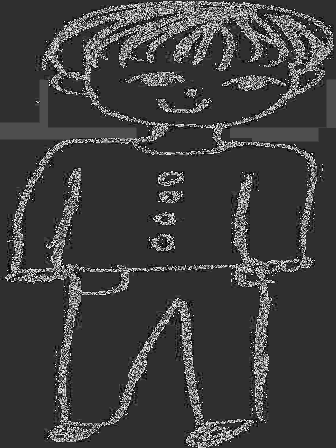

In [8]:
topil = transforms.ToPILImage()
topil(dataset[2][0][127])

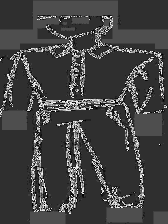

In [14]:
for i in range(128):
    topil(dataset[0][0][i]).show();break

In [59]:
for class_name in ['m', 'w'] :
    # load dataset
    data_path = f'/local_datasets/ai_hub/ai_hub_sketch_drawer/01/val/{class_name}'
    # data_path = f'/local_datasets/ai_hub/ai_hub_sketch_mw/01/val/{class_name}'
    print(data_path)
    dataset = shapley_part(data_path,'/data/datasets/ai_hub_sketch_json_asd_version',240,transform=transform)
    data_loader=DataLoader(dataset,10,shuffle=False,num_workers=8)
    print(dataset)

    # initialize
    part_number = all_ordered_pair.shape[0]
    part_count = {i: 0 for i in range(part_number)}

    num_correct = 0

    # get part shapley value
    for new_imgs, original_image, label in tqdm(data_loader):
        # print(new_imgs.shape)
        input_data = new_imgs
        # print('complete')
        batch_size = input_data.shape[0]
        input_data = rearrange(input_data,  'b t c h w -> (b t) c h w')
        
        model.to(device)
        input_data = input_data.to(device)
        original_image = original_image.to(device)
        label = label.to(device)

        with torch.no_grad():
            prediction = model(original_image)
            output = model(input_data)

        output = rearrange(output, '(b t) o -> b t o', b=batch_size) # batch_size, 128, output(2)
        prediction = prediction.argmax(dim=-1)
        # print(output.shape)
        # print(label)
        
        for i in range(batch_size):
            if prediction[i] == label[i]:
                num_correct +=1
                correct_output = output[:,:,label[i]]# Take correct logits,  (b, 128), 밖에서. 
                shapley_matrix = get_shapley_matrix(all_ordered_pair,correct_output[i])
                shapley_contributions = shapley_matrix[:,:,1] - shapley_matrix[:,:,0] 
                shapley_value = (shapley_contributions * 1/weights).sum(dim=1)
                max_part_number = (int(shapley_value.argmax()))
                part_count[max_part_number] += 1
    print(part_count)
    print(num_correct)
    print(num_correct/dataset.__len__())
    
    #! plot    
    # 주어진 딕셔너리
    part=['Hair', "Eye", "Nose", "Ear", "Mouth", "Hand", "Foot"]
    data=part_count
    data2={}
    for i in range(7):
        data2[part[i]]=list(data.values())[i]
    # {0: 1139, 1: 5, 2: 3, 3: 47, 4: 5, 5: 5, 6: 2}
    # 딕셔너리의 key와 value를 각각 리스트로 추출
    x = list(data2.keys())
    y = list(data2.values())

    # 그래프 생성
    plt.bar(x, y)

    # x축과 y축에 라벨 추가
    plt.xlabel('Part')
    plt.ylabel('Count')

    # 그래프 제목 추가
    class_name = 'Man' if class_name == 'm' else 'Woman'
    plt.title(f'Drawer M/W classification : {class_name} samples\n{num_correct}/{len(dataset)}={num_correct/len(dataset)*100:.2f}%')
    # 그래프 표시
    plt.show()

/local_datasets/ai_hub/ai_hub_sketch_drawer/01/val/m


 70%|███████   | 103/147 [02:12<00:56,  1.29s/it]


KeyboardInterrupt: 

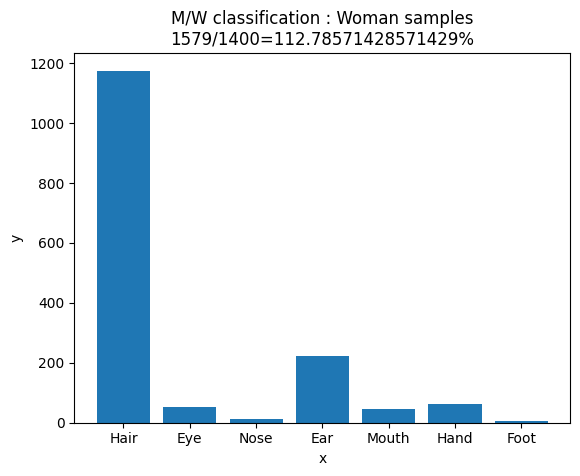

In [ ]:
part=['Hair', "Eye", "Nose", "Ear", "Mouth", "Hand", "Foot"]
data=part_count
data2={}
for i in range(7):
    data2[part[i]]=list(data.values())[i]
# {0: 1139, 1: 5, 2: 3, 3: 47, 4: 5, 5: 5, 6: 2}
# 딕셔너리의 key와 value를 각각 리스트로 추출
x = list(data2.keys())
y = list(data2.values())

# 그래프 생성
plt.bar(x, y)

# x축과 y축에 라벨 추가
plt.xlabel('x')
plt.ylabel('y')

# 그래프 제목 추가
class_name = 'Woman'
plt.title(f'M/W classification : {class_name} samples\n{num_correct}/{len(dataset)}={num_correct/len(dataset)*100}%')
# 그래프 표시
plt.show()

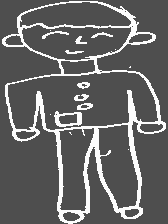

In [56]:
# dataset[22][0]['only_hair'][0].show()
# dataset[22][0]['head'][0].show()
# dataset[22][0]['face'][0].show()
# dataset[22][0]['only_face'][0].show()
# dataset[22][0]['empty_upper_body'][0].show()
# dataset[22][0]['empty_face'][0].show()
topil(dataset[0][1]).show()

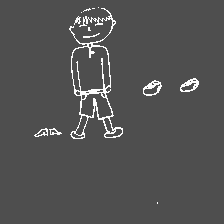

In [21]:
img = Image.open('/data/datasets/ai_hub/ai_hub_sketch_mw/01/train/m/m_10_m_00110.jpg')
img = transform(img)
topil(img).resize((224,224))

In [ ]:
Image.open('/data/datasets/ai_hub/ai_hub_sketch_mw/01/val/w/w_10_m_00389.jpg').size

In [ ]:
data

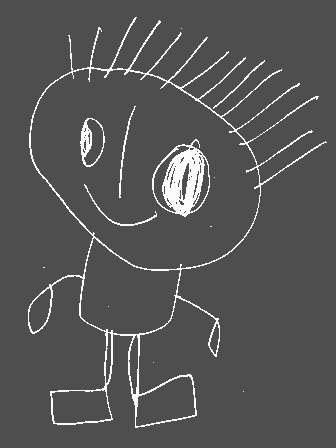

In [38]:
from PIL import Image
transform = transforms.Compose([transforms.Resize((448,336)),
                                transforms.Grayscale(3),
                                transforms.ToTensor(),
                                ThresholdTransform(220),
                                transforms.Normalize(mean=[0.98, 0.98, 0.98],
                                    std=[0.065, 0.065, 0.065])
                                ])
img = Image.open('/data/datasets/asd/All_5split/01/val/ASD/A-2-o2.jpg')
img =transform(img)
topil(img).show()